In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pyBigWig
from biodata.delimited import DelimitedReader
import biodataplot.genomeview as gv
import biodataplot.utils as bpu
import math
from biodatatools.utils.common import json_load
from pathlib import Path

In [2]:
matplotlib.font_manager.fontManager.addfont(f"{Path.cwd().parent}/font/Arial.ttf")
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9

In [3]:
PROJECT_DIR_d = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/PROcap/"
PROJECT_DIR_r = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/"
PROJECT_DIR_o = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/"

# Get TSS position

In [4]:
# Only focus on divergent elements with CTCF binding, minTSS vs. maxTSS (control)
# Check how minTSS position changes before and after treatment in upregulated vs. unchanged group

In [4]:
s = "HCT116"
ks = ["pl", "mn"]
p = "divergent"
ds = ["distal", "proximal"]
t = "minTSS"
labels = ["Up", "Unchanged"]

In [5]:
def get_prominent_TSSs(inputfile, bw_files):
	bws = [pyBigWig.open(bw) for bw in bw_files]
	
	results = []
	with DelimitedReader(inputfile) as dr:
		for cols in dr:
			chrom, start, end, _, _, tss1, tss2, sign = cols
			# UT: use TSS called by PINTS
			# fwd, rev
			tss_UT = [int(tss2), int(tss1)]

			# T: find the position with the highest signals; if there are > 1 highest TSSs, keep the one closer to the TSS called at UT
			# fwd, rev
			tss_T = [np.nan, np.nan]
			for n in range(2):
				try:
					scores = {}
					for zstart, ostop, score in bws[n].intervals(chrom, int(start), int(end)):
						for pos in range(max(int(start), zstart), min(int(end), ostop)):
							scores[pos] = abs(score)
					max_value = max(scores.values())
					max_keys = [key for key, value in scores.items() if value == max_value]
					tss_T[n] = min(max_keys, key=lambda k: abs(k - tss_UT[n]))	
				except:
					# No reads found in this region at T
					continue
							
			if not any(math.isnan(x) for x in tss_T):
				# For consistency of interpretation, set the sign in a way that
				# positive values: go downstream of the original TSS
				# negative values: go upstream of the original TSS
				distance = [tss_T[0]-tss_UT[0], tss_UT[1]-tss_T[1]]
				if sign == "+":
					minTSS_distance, maxTSS_distance = distance[1], distance[0]
				else:
					minTSS_distance, maxTSS_distance = distance[0], distance[1]
				results.extend([["_".join([chrom, start, end]), minTSS_distance, "minTSS"],
								["_".join([chrom, start, end]), maxTSS_distance, "maxTSS"]
							   ])

	df = pd.DataFrame(results, columns=["element", "distance", "TSS_type"])
	return df

In [6]:
# T
bws = [f"{PROJECT_DIR_d}Alignments/brm_CTCF_T1_and_CTCF_T2_erm_5{k}.bw" for k in ks]

In [7]:
dfs = {}
for d in ds:
	inputfile = f"{PROJECT_DIR_d}bed_plot/{s}_{p}_{d}.bed"
	dfs[d] = get_prominent_TSSs(inputfile, bws)

# Check TSS changes

In [8]:
binding_labels = json_load(f"{PROJECT_DIR_o}labels/{s}_CTCF_ChIP.json")

In [9]:
DE_labels = json_load(f"{PROJECT_DIR_o}labels/{s}_CTCF_DE.json")

In [10]:
filtered_df = {}
for d in ds:
	filtered_df[d] = dfs[d][dfs[d]["element"].astype(str).isin([k for k, v in binding_labels.items() if v == "CTCF binding"])].copy()
	filtered_df[d]["Label"] = filtered_df[d]["element"].astype(str).map(DE_labels[t])

In [11]:
def plot_distance(df, outputfile):
	fig, ax = plt.subplots(1,2,figsize=(4.2, 2.3))
	for label in labels:
		col = labels.index(label)
		df2 = df[df["Label"]==label].copy()
		g = sns.kdeplot(data=df2, x="distance", hue="TSS_type",
						palette=["#2c7bb6", "#d7191c"],
						hue_order=["minTSS", "maxTSS"], 
						ax=ax[col])
		g.set_title(f"{label} (n={len(set(df2['element']))})", fontsize=bfontsize)
		g.spines[["right", "top"]].set_visible(False)
		
		if col == 0:
			g.set_ylabel("Density", fontsize=bfontsize)
			g.get_yaxis().set_label_coords(-0.4, 0.5)
			g.legend([],[], frameon=False)
		else:
			g.set_ylabel("")
			sns.move_legend(g, "upper left", bbox_to_anchor=(0.6, 1), frameon=False)
			g.legend_.set_title("")
			for text in g.legend_.get_texts():
				text.set_fontsize(sfontsize)
		
		g.set_xticks([-400, -200, 0, 200])
		g.set_xlabel("\u0394TSS position (bp)", fontsize=bfontsize)
		
	fig.subplots_adjust(wspace=0.5)
	plt.savefig(outputfile, bbox_inches="tight", transparent=True)

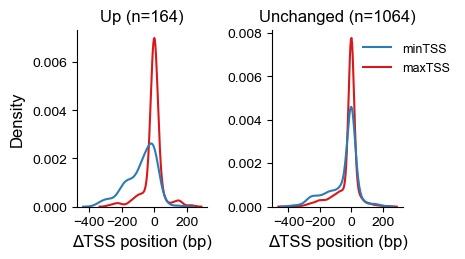

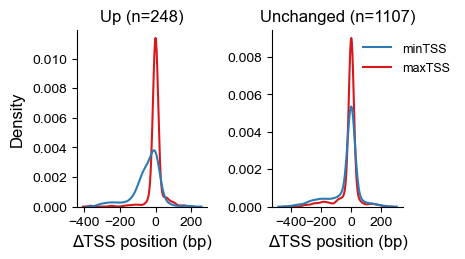

In [12]:
for d in ds:
	folder = "figures/" if d == "distal" else "other_figures/"
	outputfile = f"{PROJECT_DIR_o}{folder}ExtDataFig10a.pdf"
	plot_distance(filtered_df[d], outputfile)

# Example browser shot

In [20]:
rpms = {"UT, rep1": [f"{PROJECT_DIR_d}Alignments/CTCF_U1_5{k}_rpm.bw" for k in ks],
	   "UT, rep2": [f"{PROJECT_DIR_d}Alignments/CTCF_U2_5{k}_rpm.bw" for k in ks],
	   "T, rep1": [f"{PROJECT_DIR_d}Alignments/CTCF_T1_5{k}_rpm.bw" for k in ks],
	   "T, rep2": [f"{PROJECT_DIR_d}Alignments/CTCF_T2_5{k}_rpm.bw" for k in ks],
		}

In [14]:
def _expand_genomic_pos(r, size):
	from genomictools import GenomicPos
	r = GenomicPos(r)
	s = size - len(r)
	return GenomicPos(r.name, r.start - (s // 2), r.stop + (s // 2 + s % 2))

In [18]:
def plot_example(region, color, outputfile, size=500):
	chrom = region.split(':')[0]
	region = _expand_genomic_pos(region, size)
	
	data = {}
	for m in rpms:
		data[f"PRO-cap ({m})"] = rpms[m]
	data["CTCF ChIP (UT)"] = f"{PROJECT_DIR_r}other/GSE179545/GSM5420199_I_Con_CTCF_hg38.bw"
	data["CTCF ChIP (T)"] = f"{PROJECT_DIR_r}other/GSE179545/GSM5420200_I_IAA_CTCF_hg38.bw"
	data["CTCF motif"] = f"{PROJECT_DIR_o}FIMO/{s}_CTCF_pos.bed"
	
	# formatters = {}
	formatters = {
			"CTCF ChIP (UT)": {"plot_kw": {"fill_kw":{"color":color}}},
			"CTCF ChIP (T)": {"plot_kw": {"fill_kw":{"color":color}}},
			"CTCF motif": {"plot_kw": {"facecolor":color}, "anno_vspace": 0}
			}
	height_ratios = {}
	for k in data:
		if "PRO-cap" in k:
			formatters[k] = {"yscale":"asym_pos_neg", "plot_kw":{"width":3}}
			height_ratios[k] = 8
		elif "ChIP" in k:
			height_ratios[k] = 5
		else:
			height_ratios[k] = 3
	
	fig = gv.plot_genome_view(
		region,
		data = data,
		formatters = formatters,
		height_ratios = height_ratios,
		group_autoscales = [[k for k in data if "PRO-cap" in k],
							[k for k in data if "ChIP" in k]
						   ],
		coordinate_kw = {"major_coordinate_unit":150}
		)
	
	bpu.plt_change_figure_properties(
		fig,
		**{"fig_prop": {"size_inches":[3, 3.2]},
		"fig_suptitle_kwargs": {"fontsize":bfontsize},
		"xticklabels_prop": {"fontsize":sfontsize},
		"yticklabels_prop": {"fontsize":sfontsize},
		"ylabel_prop": {"fontsize":bfontsize},
		"xlabel_prop": {"fontsize":bfontsize}
		},
		title_prop = {"text": ""}
		)

	bpu.plt_change_figure_properties(
		fig, 
		ax_targets=[-1],
		xlabel_prop={"text":f"Genomic position ({chrom})"}
		)

	for i in range(len(data)):
		fig.axes[i].yaxis.set_label_coords(-0.2, 0.5)
		fig.axes[i].yaxis.set_major_formatter(lambda s, pos: f"{s:.0f}")
		
	fig.savefig(outputfile, bbox_inches="tight", transparent=True)

In [ ]:
# minTSS, divergent distal

region = "chr3:43769422-43769923"
color = "#FFD700"
outputfile = f"{PROJECT_DIR_o}figures/ExtDataFig10b.pdf"
plot_example(region, color, outputfile)